In [15]:
from collections import defaultdict
import csv
from datetime import datetime
import statistics
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

In [16]:
with open(f"Uber Rides.csv", 'r') as file:
    rides = list(csv.DictReader(file))
    for ride in rides:
        ride['datetime'] = datetime.strptime(ride['datetime'], '%Y-%m-%d %H:%M:%S')
        ride['day_of_week'] = int(ride['day_of_week'])
        ride['earnings'] = float(ride['earnings'])
        ride['tip'] = float(ride['tip'])
        ride['surge'] = float(ride['surge'])
        ride['duration'] = int(ride['duration'])
        ride['distance'] = float(ride['distance'])
        ride['earnings-surge'] = float(ride['earnings-surge'])
        ride['earnings/second'] = float(ride['earnings/second'])
        ride['earnings/mile'] = float(ride['earnings/mile'])

print(f"Read {len(rides)} rides.")
print(rides[0])

Read 2890 rides.
{'uuid': 'd3096d6c-02bd-4f8e-855b-117588b27910', 'date': '2023-01-15', 'time': '13:05:57', 'datetime': datetime.datetime(2023, 1, 15, 13, 5, 57), 'day': 'Sunday', 'day_of_week': 6, 'sortable_day_of_week': '6 - Sunday', 'season': 'Winter', 'type': 'Comfort', 'earnings': 10.72, 'tip': 1.0, 'surge': 0.0, 'duration': 956, 'distance': 3.9, 'pickup_address': 'N Ashland Ave, Chicago, IL 60614-1101, US', 'dropoff_address': 'W Madison St, Chicago, IL 60612, US', 'earnings-surge': 10.72, 'earnings/second': 0.011213389121338914, 'earnings/mile': 2.7487179487179487, 'pickup_zipcode': '60614', 'dropoff_zipcode': '60612'}


In [17]:
# Create a defaultdict to store the edge weights (frequencies)
edge_weights = defaultdict(int)

for ride in rides:
    pickup = ride['pickup_zipcode']
    dropoff = ride['dropoff_zipcode']
    if pickup is not None and dropoff is not None:
        edge_weights[(pickup, dropoff)] += 1

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for (pickup, dropoff), weight in edge_weights.items():
    G.add_edge(pickup, dropoff, weight=weight)

# Find zip codes that are never dropoffs (in-degree zero)
never_dropoff_zipcodes = sorted([node for node, in_degree in G.in_degree() if in_degree == 0])

# Find zip codes that are never pickups (out-degree zero)
never_pickup_zipcodes = sorted([node for node, out_degree in G.out_degree() if out_degree == 0])

# Calculate the in-degrees of all nodes
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Find the maximum in-degree
max_in_degree = max(in_degrees.values())
max_out_degree = max(out_degrees.values())

# Find zip codes with maximum in-degree (maximum dropoffs)
max_dropoff_zipcodes = [node for node, degree in in_degrees.items() if degree == max_in_degree]

# Find zip codes with maximum out-degree (maximum pickups)
max_pickup_zipcodes = [node for node, degree in out_degrees.items() if degree == max_out_degree]

print("Zip codes I picked up from and never dropped off to:", never_dropoff_zipcodes)
print("Zip codes I dropped off to and never picked up from:", never_pickup_zipcodes)
print("Zip codes that I've picked up from the most:", max_pickup_zipcodes)
print("Zip codes that I've dropped off to the most:", max_dropoff_zipcodes)
print("Total number of zip codes picked up from or dropped off to:", len(G.nodes()))

Zip codes I picked up from and never dropped off to: ['46394', '60005', '60016', '60040', '60101', '60104', '60106', '60164', '60456', '60515', '60534', '60561']
Zip codes I dropped off to and never picked up from: ['', '06061', '60004', '60007', '60008', '60026', '60043', '60044', '60056', '60085', '60148', '60162', '60171', '60181', '60192', '60301', '60453', '60457', '60459', '60477', '60521', '60525', '60558', '60617', '60633', '60643', '60827']
Zip codes that I've picked up from the most: ['60647']
Zip codes that I've dropped off to the most: ['60611']
Total number of zip codes picked up from or dropped off to: 131


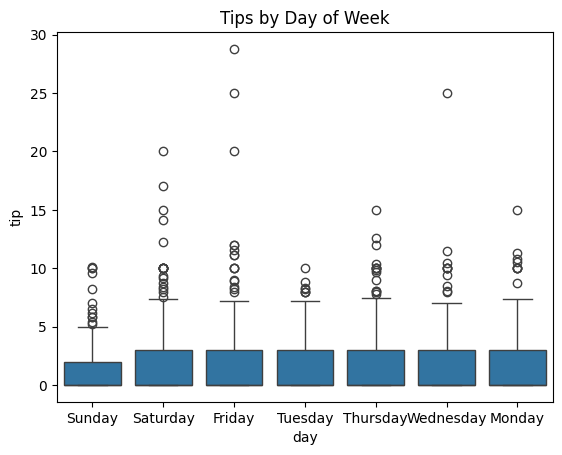

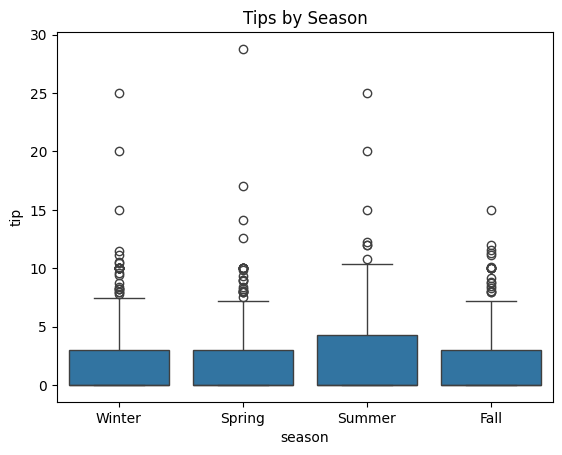

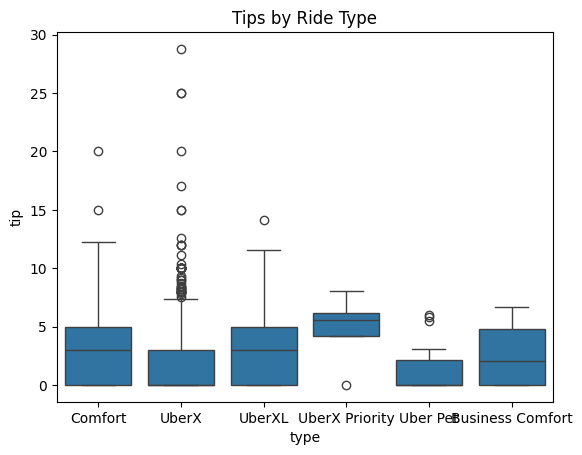

In [18]:
df = pd.DataFrame(rides)

# Boxplots for categorical variables
sns.boxplot(x='day', y='tip', data=df)
plt.title('Tips by Day of Week')
plt.show()

sns.boxplot(x='season', y='tip', data=df)
plt.title('Tips by Season')
plt.show()

sns.boxplot(x='type', y='tip', data=df)
plt.title('Tips by Ride Type')
plt.show()

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA for categorical variables
model = ols('tip ~ C(day_of_week) + C(season) + C(type) + C(pickup_zipcode) + C(dropoff_zipcode)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq      df          F        PR(>F)
C(day_of_week)         58.953216     6.0   1.739037  1.079827e-01
C(season)              80.332673     3.0   4.739402  2.666361e-03
C(type)               365.400008     5.0  12.934544  1.863763e-12
C(pickup_zipcode)     847.817946   103.0   1.456860  2.164090e-03
C(dropoff_zipcode)   2068.181852   118.0   3.102125  7.066874e-25
Residual            15023.314926  2659.0        NaN           NaN


In [20]:
tips_by_pickup_zipcode = defaultdict(lambda: [])
tips_by_dropoff_zipcode = defaultdict(lambda: [])
for ride in rides:
    tips_by_pickup_zipcode[ride['pickup_zipcode']].append(ride['tip'])
    tips_by_dropoff_zipcode[ride['dropoff_zipcode']].append(ride['tip'])

avg_tip_by_pickup_zipcode = {}
avg_tip_by_dropoff_zipcode = {}
for zipcode, tips in tips_by_pickup_zipcode.items():
    avg_tip_by_pickup_zipcode[zipcode] = statistics.mean(tips)
for zipcode, tips in tips_by_dropoff_zipcode.items():
    avg_tip_by_dropoff_zipcode[zipcode] = statistics.mean(tips)

print("Avg Tip by Pickup Zipcode:")
for zipcode, avg_tip in sorted(avg_tip_by_pickup_zipcode.items(), key=lambda x: x[1], reverse=True):
    print(f"{zipcode}: ${avg_tip:.2f} ({len(tips_by_pickup_zipcode[zipcode])})")
print("Avg Tip by Dropoff Zipcode:")
for zipcode, avg_tip in sorted(avg_tip_by_dropoff_zipcode.items(), key=lambda x: x[1], reverse=True):
    print(f"{zipcode}: ${avg_tip:.2f} ({len(tips_by_dropoff_zipcode[zipcode])})")

Avg Tip by Pickup Zipcode:
60126: $14.15 (1)
60160: $9.53 (3)
60069: $8.79 (1)
60515: $7.03 (1)
60656: $6.00 (5)
60089: $5.00 (1)
60018: $4.67 (7)
60523: $3.00 (1)
60091: $2.93 (11)
60714: $2.80 (5)
60068: $2.69 (2)
60637: $2.68 (16)
60638: $2.65 (5)
60666: $2.50 (2)
60652: $2.50 (2)
60062: $2.50 (2)
60603: $2.47 (26)
60630: $2.45 (11)
60616: $2.21 (39)
60641: $2.15 (33)
60712: $2.00 (6)
60534: $2.00 (1)
60625: $1.96 (54)
60653: $1.91 (6)
60613: $1.89 (122)
60640: $1.88 (117)
60611: $1.84 (129)
60601: $1.83 (41)
60302: $1.80 (4)
60642: $1.76 (99)
60605: $1.75 (62)
60077: $1.67 (14)
60093: $1.67 (3)
60053: $1.66 (3)
60661: $1.62 (57)
60201: $1.53 (57)
60614: $1.52 (186)
60606: $1.51 (36)
60626: $1.51 (60)
60131: $1.50 (2)
60631: $1.50 (8)
60164: $1.50 (2)
60647: $1.46 (259)
60660: $1.44 (65)
60608: $1.42 (50)
60604: $1.41 (9)
60612: $1.40 (59)
60657: $1.39 (187)
60622: $1.35 (185)
60618: $1.34 (95)
60402: $1.33 (3)
60610: $1.31 (98)
60602: $1.29 (14)
60654: $1.25 (110)
60632: $1.25 (7)
